In [1]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from copy import deepcopy
import pickle as pkl
from matplotlib.animation import FuncAnimation
from IPython.display import display, HTML
import sys
from shapely.geometry import Point, Polygon, LineString

# MCTS code imports
sys.path.append("..")  # Adds higher directory to python modules path.
from static_kf import measurement_model

Sensor bearing: 29.999999999999993
R = [[ 5.80616758 -1.39632321]
 [-1.39632321  7.41850275]]
eigvals = [5.         8.22467033]
eigvecs = [[-0.8660254  0.5      ]
 [-0.5       -0.8660254]]
eigvec1_angle = -150.0


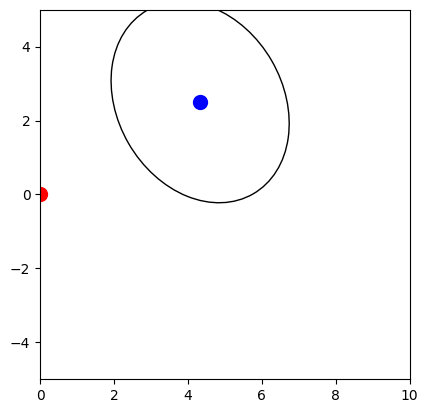

In [9]:
car_pos = np.array([0, 0])
ooi_pos = np.array([5, 0]).reshape(1,2)

# Rotate the ooi position
theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
R = np.array([[c, -s], [s, c]])
ooi_pos = np.dot(R, ooi_pos.T).T

R = measurement_model(ooi_pos, np.array([0]), car_pos, 0., range_dev=1., bearing_dev=1.)
print(f'R = {R}')

eigvals, eigvecs = np.linalg.eig(R)
print(f'eigvals = {eigvals}')
print(f'eigvecs = {eigvecs}')

# Angle of first eigen column vector
eigvec1 = eigvecs[:,0] # First column
eigvec1_angle = np.arctan2(eigvec1[1], eigvec1[0])
print(f'eigvec1_angle = {np.degrees(eigvec1_angle)}')

# plot the car ooi and covariance
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0, 10)
ax.set_ylim(-5, 5)
ax.plot(car_pos[0], car_pos[1], 'ro', markersize=10)
ax.plot(ooi_pos[0,0], ooi_pos[0,1], 'bo', markersize=10)
ax.add_patch(patches.Ellipse((ooi_pos[0,0], ooi_pos[0,1]), 2*np.sqrt(eigvals[0]), 2*np.sqrt(eigvals[1]), angle=np.degrees(eigvec1_angle), fill=False))
